In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [3]:
def get_file_name(path):
    file_name = []
    for file in os.listdir(path):
        if file.endswith('.png'):
            file_name.append(file)
            
    file_name.sort(key=lambda x:int(x[1:-4]))
    return file_name

def get_label(path):
    name = ''
    dictionary = {}
    file = open(path + "spec_train_val.txt", "r")
    file = file.read().split('\n')
    
    max_len = 0
    for row in file:
        if len(row.split(' ')) >= 2:  
            name, label = row.split(' ')[0], row.split(' ')[1]
            if len(label) > max_len:
                max_len = len(label)
            dictionary.update({name: label})
        
    return dictionary, max_len

In [4]:
IMAGE_WIDHT = 300
IMAGE_HEIGHT = 160
BATCH_SIZE = 8
train_data_size = 120000
MAX_WIDTH = 27
PATH = './words_captcha/'
label_dict, MAX_HEIGHT = get_label(PATH)

In [5]:
class DatasetGenerator:
    def __init__(self):
        image_dict = get_file_name(PATH)
        label_dict, MAX_HEIGHT = get_label(PATH)
        
        self.label = []
        self.image_name = []
        for name in image_dict:
            name_number = name.split('.')[0]
            if int(name_number[1:]) < train_data_size:
                label_array = self.preprocess_label(label_dict[name_number])
                self.label.append(label_array)
                self.image_name.append(name)
    
    def preprocess_label(self, label):
        label_array = np.zeros(MAX_HEIGHT * MAX_WIDTH)
        for i in range(MAX_HEIGHT):
            if i < len(label):
                idx = i*MAX_WIDTH + ord(label[i]) - ord('a')
                label_array[idx] = 1
            else:
                idx = i*MAX_WIDTH + MAX_WIDTH - 1
                label_array[idx] = 1
        
        label_array = label_array.reshape(-1, MAX_WIDTH)
        return label_array
    @tf.function
    def map_fn(self, image_name, label):
        image_file = tf.io.read_file(PATH+image_name)
        image = tf.io.decode_jpeg(image_file, channels=1)        
        image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDHT))
        image = (image/255) * 2 - 1
        
        return image, label
        
    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_name, self.label))
        
        train_size = 100000
        val_size = 20000
        
        train_dataset = dataset.take(train_size)
        val_dataset = dataset.skip(train_size)
        val_dataset = val_dataset.take(val_size)
        
        train_dataset = train_dataset.shuffle(100000)
        train_dataset = train_dataset.map(self.map_fn,
                                          num_parallel_calls = tf.data.experimental.AUTOTUNE)
        train_dataset = train_dataset.batch(BATCH_SIZE)
        train_dataset = train_dataset.prefetch(buffer_size=200)
        
        val_dataset = val_dataset.shuffle(100000)
        val_dataset = val_dataset.map(self.map_fn,
                                      num_parallel_calls = tf.data.experimental.AUTOTUNE)
        val_dataset = val_dataset.batch(BATCH_SIZE)
        val_dataset = val_dataset.prefetch(buffer_size=200)
        
        return train_dataset, val_dataset

In [6]:
train_dataset, val_dataset = DatasetGenerator().generate()  

wire{


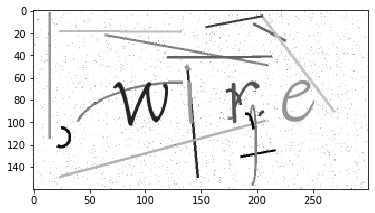

In [7]:
def predict_valid(label):
    label = label.numpy()
    result = ''
    for i in range(label.shape[0]):
        index = np.argmax(label[i])
        result += chr(index+ord('a'))
        
    return result

for image, label in train_dataset.take(1):
    print(predict_valid(label[0]))
    
    image_int = (image[0]+1)/2*255
    image_int = image_int.numpy().astype('int32')
    image_int = image_int[:,:,0]
    plt.imshow(image_int, cmap = plt.cm.gray)
    plt.show()

In [8]:
from tensorflow import keras
from tensorflow.keras import layers, models

model = models.Sequential(name = 'model')

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDHT, 1)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(MAX_WIDTH * MAX_HEIGHT))
model.add(tf.keras.layers.Reshape([MAX_HEIGHT, MAX_WIDTH]))

model.add(layers.Activation('softmax'))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 300, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 300, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 150, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 150, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 150, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 150, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 75, 64)        0     

In [9]:
model.compile(optimizer='Adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')

In [10]:
CKP_DIR_SAVE_CHECKPOINTS = './checkpoints_save_checkpoints'

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), model=model)
manager = tf.train.CheckpointManager(ckpt, CKP_DIR_SAVE_CHECKPOINTS, max_to_keep=3)

In [11]:
epochs = 100

ckpt.restore(manager.latest_checkpoint)
for epoch in range(epochs):
    ckpt.epoch.assign_add(1)
    
    model.fit(train_dataset)
    model.evaluate(val_dataset)
    
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path)) 

2500/2500 [==============================] - 41s 16ms/step - loss: 0.0640 - accuracy: 0.9813
Saved checkpoint for epoch 15: ./checkpoints_save_checkpoints/ckpt-13
2500/2500 [==============================] - 40s 16ms/step - loss: 0.0838 - accuracy: 0.9772
Saved checkpoint for epoch 16: ./checkpoints_save_checkpoints/ckpt-14
2500/2500 [==============================] - 40s 16ms/step - loss: 15.1897 - accuracy: 0.0243
Saved checkpoint for epoch 17: ./checkpoints_save_checkpoints/ckpt-15
2500/2500 [==============================] - 39s 16ms/step - loss: 0.0831 - accuracy: 0.9808
Saved checkpoint for epoch 18: ./checkpoints_save_checkpoints/ckpt-16
    116/Unknown - 4s 31ms/step - loss: 0.0586 - accuracy: 0.9793

KeyboardInterrupt: 

In [ ]:
model.evaluate(val_dataset)

In [12]:
class TestDatasetGenerator:
    def __init__(self):
        image_dict = get_file_name(PATH)
        
        self.image_name = []
        for name in image_dict:
            name_number = name.split('.')[0]
            if int(name_number[1:]) >= train_data_size:
                self.image_name.append(name)
    
    @tf.function
    def map_fn(self, image_name):
        image_file = tf.io.read_file(PATH+image_name)
        image = tf.io.decode_jpeg(image_file, channels=1)        
        image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDHT))
        image = (image/255) * 2 - 1
        
        return image
        
    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_name))
    
        dataset = dataset.map(self.map_fn,
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=200)
        
        return dataset
    
testdataset = TestDatasetGenerator().generate() 

testdataset

<PrefetchDataset shapes: (None, 160, 300, 1), types: tf.float32>

In [17]:
ckpt.restore(manager.latest_checkpoint)

result = model.predict(testdataset)

fail


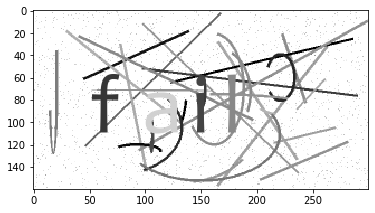

nil


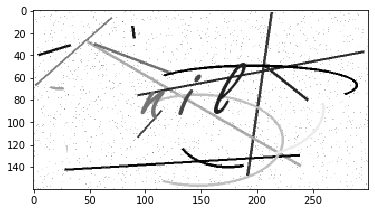

dumb


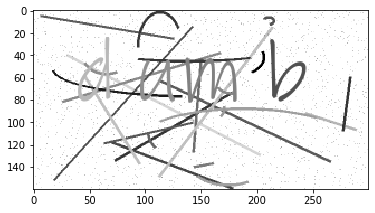

scott


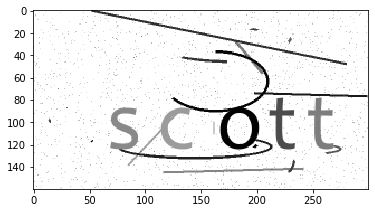

main


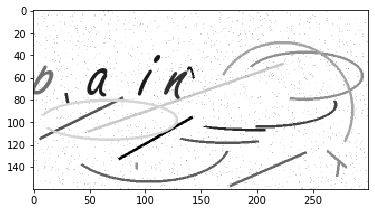

notes


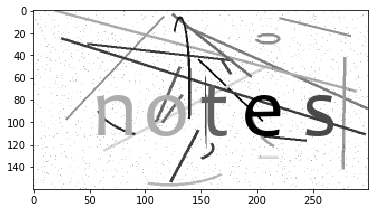

keee


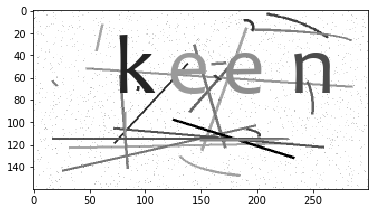

tape


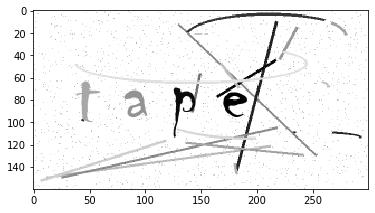

tech


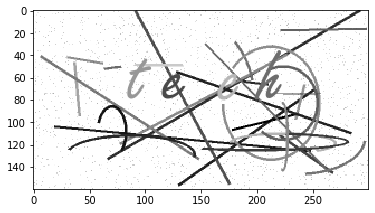

actor


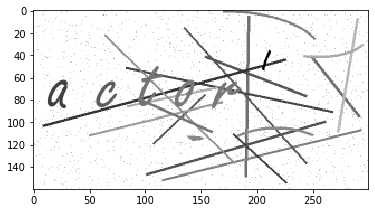

In [19]:
def predict_test(label):
    result = ''
    for i in range(label.shape[0]):
        index = np.argmax(label[i])
        if index != 26:
            result += chr(index+ord('a'))
        
    return result

idx = 0
for image in testdataset.take(10):
    print(predict_test(result[idx]))
    idx += BATCH_SIZE
    
    image_int = (image[0]+1)/2*255
    image_int = image_int.numpy().astype('int32')
    image_int = image_int[:,:,0]
    plt.imshow(image_int, cmap = plt.cm.gray)
    plt.show()

In [ ]:
if not os.path.isdir('./output'):
    os.mkdir('./output')

f = open('./output/Lab13-2_108062592.txt', 'w').close()

test_fileNames = get_file_name(PATH)[120000:]
with open('./output/Lab13-2_108062592.txt', 'a') as file:
    for i in range(len(test_fileNames)):
        tmp = predict_test(result[i])
        file.write(str(test_fileNames[i].split('.')[0]) + ' \t ' + tmp + '\n')

# report
## 我先把label用成[5, 27]的array，5是label的最大長度，27是英文字母數量+空白(26+1)，接下來用CNN predict，最後用一個softmax輸出結果